### DBSCAN implementation
- build the data
- parameters: minPts, epsilon ($\epsilon$)
- define `core` points $p$ that are surrounded by at least minPts within an epsilon radius
- define `directly reachable points` $q$ from $p$ that lie within a circle of radius $\epsilon$ around $p$
- define `reacheable points` $q$ from $p$ that is points that are directly reacheable by a previous point and so on step-by-step
- define `outliers` meaning points that are no reacheable by any points

#### Build the data

In [97]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [98]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [99]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [5]:
from torch.distributions import MultivariateNormal

In [6]:
n_centers = 5
n_pts = 1500
centers = torch.rand(n_centers, 2)*300-150
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-105.287,   -4.034],
         [ 145.698,  -99.480],
         [  25.183,   58.080],
         [  24.925, -111.469],
         [  21.637,  127.452]]))

In [7]:
g = MultivariateNormal(centers[0], torch.diag(tensor([5.,5.])))

In [8]:
g.sample((3,))

tensor([[-104.506,   -2.888],
        [-102.589,   -0.893],
        [-110.551,   -1.490]])

In [9]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [10]:
data_l = [generate_points(c,100.) for c in centers]
data = torch.cat(data_l)

In [11]:
data.shape

torch.Size([7500, 2])

In [12]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1)
        plt.plot(*c, marker='x', markersize=10, color='k', mew=5)
        plt.plot(*c, marker='x', markersize=5, color='r', mew=1)

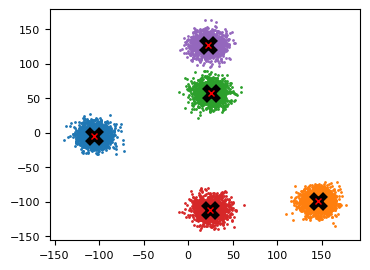

In [13]:
plot_data(centers, data_l)

#### Build the algorithm:
- for each point find the surrounding points within an $\epsilon$ radius 
- identify the core points with `num_neighbors` > `minPts`
- sort all non-core points between nearby clusters if they're within $\epsilon$ of a cluster and noise

> We can do it sequentially, point by point, and exhausting the points of a cluster to then proceed to the next cluster and end with noise points.

> We can also try to accelerate the calculation if possible. We'll try that:

In [14]:
X = data.clone()

In [15]:
X = X[torch.randperm(X.shape[0])]

In [16]:
x0 = X[0]
x1 = X[1]
(x0-X)[:3], (x1-X)[:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [17]:
X[:,None,:].shape, X.shape

(torch.Size([7500, 1, 2]), torch.Size([7500, 2]))

> Distance calculation with einsum:

In [66]:
Diff = X[:,None,:]-X
Diff[0,:3], Diff[1,:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [19]:
D = torch.einsum('ijk,ijk->ij', Diff, Diff).sqrt()
D.shape, D

(torch.Size([7500, 7500]),
 tensor([[  0.000, 205.003,   6.737,  ..., 205.918, 190.306, 185.311],
         [205.003,   0.000, 199.533,  ...,   8.269,  19.068, 136.821],
         [  6.737, 199.533,   0.000,  ..., 200.612, 184.604, 178.605],
         ...,
         [205.918,   8.269, 200.612,  ...,   0.000,  25.441, 144.476],
         [190.306,  19.068, 184.604,  ...,  25.441,   0.000, 119.664],
         [185.311, 136.821, 178.605,  ..., 144.476, 119.664,   0.000]]))

In [20]:
epsilon = 3
minPts = 20

> Now let's determine the neighbors of each point within a circle of radius $\epsilon$ :

In [21]:
def epsilon_cut(D, epsilon): return torch.where(D<epsilon, 1,0)

In [22]:
neighbors = epsilon_cut(D, epsilon)
neighbors

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

> Core points are defined as having `minPts` neighbors:

In [23]:
def core_pts_calc(D, epsilon): return torch.where(epsilon_cut(D, epsilon).sum(1)>=minPts, 1,0)

In [24]:
core_bool = core_pts_calc(D, epsilon)

In [25]:
core_bool.shape, core_bool

(torch.Size([7500]), tensor([1, 1, 1,  ..., 1, 1, 1]))

In [26]:
X_c = X[core_bool==1]
X_nc = X[core_bool==0]
X_c.shape, X_nc.shape, (X_c.shape[0] + X_nc.shape[0])

(torch.Size([5435, 2]), torch.Size([2065, 2]), 7500)

In [27]:
def plot_core(X, core_bool):
    X_c = X[core_bool==1]
    X_nc = X[core_bool==0]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(X_c[:,0], X_c[:,1], s=1)
    ax.scatter(X_nc[:,0], X_nc[:,1], s=1)
#     c = plt.Circle((-35.5, 49), 2, color='k', fill=False)
#     ax.add_patch(c)

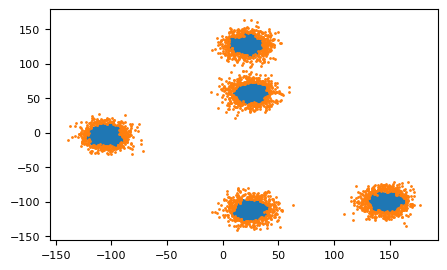

In [28]:
plot_core(X, core_bool)

> Now let's build the cluster search algorithm, the steps are as follow:

>- initialize a cluster vector of length n_points  $-$  init at 0 = belongs to no cluster
>- get the neighbors matrix
>- get the neighbor matrix of only the core points
>- go through the core points 
    - verify if any of the neighbors already has a cluster value 
    - assign all neighbors to the same cluster value, either the min value found among the neighbors to all the rest or a new one if no neighbors has any.
    - in case neighbors points are already assigned, record their previous cluster values and assign all the points that share these cluster numbers to the same min value obtained above. This will prevent small artefact clusters or points to remain next large cluster becasue they were assigned at different moments in the loop. Scikit-learn implementation does not do that and sometimes some artefact clusters appear in their cluster predictions (we'll see an exemple of that later). 
>- Optionally go through the points that are non core and not assigned, and add them to a border point table
>- finally all the unlabeled points should be noise (cluster number 0) 

> We'll need to use a reverse function to find the indexes at which e vector has a given value, we can use `torch.where` or `(tensor_0 == x).nonzero()`:

In [73]:
torch.where(core_bool==1)[0]

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [74]:
core_bool.nonzero().squeeze()

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [72]:
%timeit -n 1000 torch.where(core_bool==0)[0]

45.7 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [76]:
%timeit -n 1000 core_bool.nonzero().squeeze()

40.7 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [78]:
%timeit -n 1000 (core_bool==0).nonzero().squeeze()

44.2 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


> We initialize the cluster vector and build the cluster search loop trying to keep as much as possible vectorial calculations:

In [79]:
cluster = torch.zeros(X.shape[0])

core_n_idx = core_bool.nonzero().squeeze()
ncore_n_idx = (core_bool==0).nonzero().squeeze()
neighbors.shape

torch.Size([7500, 7500])

In [59]:
core_n_idx.shape

torch.Size([5435])

In [60]:
neighbors[core_n_idx][0:6]

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [38]:
%timeit -n 5 neighbors[core_n_idx][0].nonzero().squeeze()

46.7 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


> In the outer loop we go through all the core points neighbors matrix, in the inner loop we verify if the neighbors have already a value assigned to them. If they do, the idea is to find the smaller cluster value present and assign it to all of them (as they are all neighbors to a core point they are part of the same cluster). A second check is performed to assign all the other points that share these cluster values to the same min value selected above.<br>
This step is costly, we can implement it with an index search via torch.isin() or by a loop through the cluster values of the neighbors. The for loop is quite faster.

In [83]:
i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()] # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                      # cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
            cluster[idx] = c_num
        cluster[u_idx] = c_num
#         cluster[all_n_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

In [84]:
cluster

tensor([1., 2., 1.,  ..., 2., 2., 5.])

In [85]:
((cluster == 0) | (cluster ==1))

tensor([ True, False,  True,  ..., False, False, False])

In [86]:
# rest_idx = (cluster==0).nonzero().squeeze()
# # for v in neighbors[rest_idx]:
# for v in neighbors[ncore_n_idx]:
#     print(v)
#     v_idx = v.nonzero().squeeze()
#     if v.sum()>1 and cluster[v_idx].sum()>0:
#         print('dbl', v)
#         print('sum', v.sum()>1)
#         print('cluster', cluster[v_idx])
#         print('clu-sum', cluster[v_idx].sum()>0)
#         cluster[v_idx] = cluster[v_idx[cluster[v_idx].nonzero().squeeze()]].min()

In [87]:
torch.unique(cluster)

tensor([0., 1., 2., 5., 6., 7.])

In [88]:
(core_bool==0).sum(), (cluster == 0).sum() 

(tensor(2065), tensor(1229))

In [89]:
cluster[ncore_n_idx]

tensor([0., 0., 0.,  ..., 0., 7., 0.])

In [90]:
def plot_cluster(X, cluster):
#     X_c = X[core_bool==1]
#     X_nc = X[core_bool==0]
    colors = cluster
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(X[:,0], X[:,1], s=1, c=colors)
#     ax.scatter(X_nc[:,0], X_nc[:,1], s=1)
#     c = plt.Circle((-35.5, 49), 2, color='k', fill=False)
#     ax.add_patch(c)

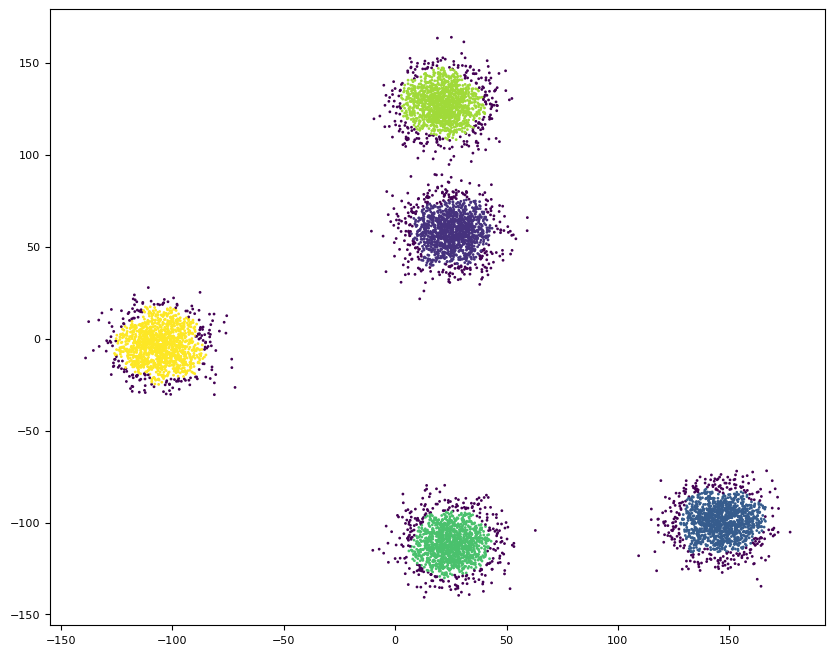

In [91]:
plot_cluster(X, cluster)

>Let's compare with the scikit-learn implementation of DBSCAN:

In [92]:
from sklearn.cluster import DBSCAN

In [93]:
y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

In [94]:
%timeit -n 10 y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

34.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> We can see that there are some islands of residual clusters in the middle of larger clusters. They likely do not check for all the other core points that were assigned to another cluster earlier and not converted to their final cluster.

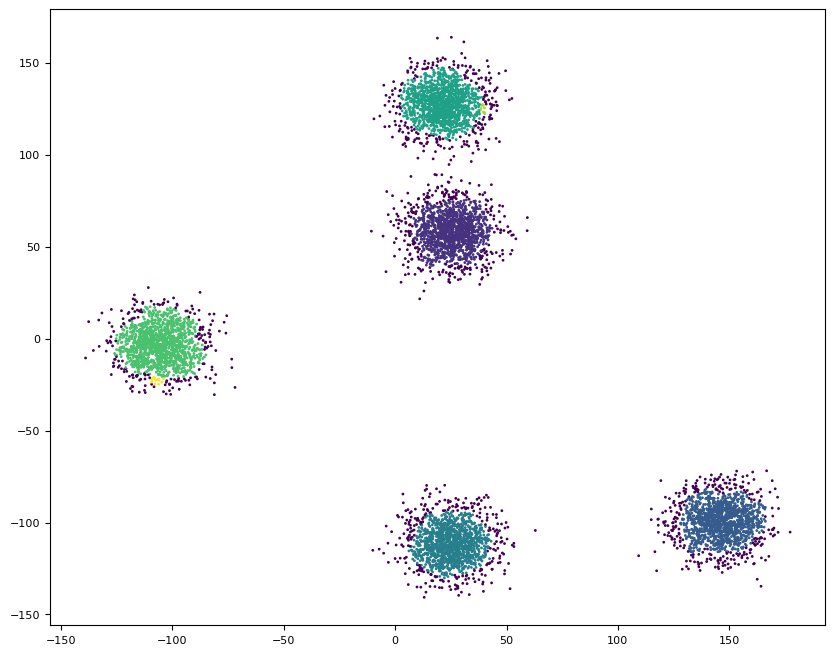

In [95]:
plot_cluster(X, y_pred)

In [286]:
neighbors = epsilon_cut(D, epsilon)

In [53]:
cluster.unique()

tensor([0., 1., 2., 5., 6., 7.])

In [288]:
nn_idx

tensor([ 25,  45,  54,  65,  78, 108, 109, 147, 167, 178, 179, 182, 205, 220, 316, 321, 391, 428, 432, 436, 454, 464, 494, 515, 544, 592,
        595, 643, 647, 672, 686, 706, 742, 744, 749])

In [157]:
%timeit -n 50 cluster.unique().min()

21.9 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [289]:
%timeit -n 50 torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()

111 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


> `torch.isin` is very slow, it is faster to perform a for loop in python:

In [57]:
%%timeit -n 3
core_bool = core_pts_calc(D, epsilon)

cluster = torch.zeros(X.shape[0])
core_n_idx = core_bool.nonzero().squeeze()


i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()]                   # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                                        # smallest cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze() # all points that share a common cluster number with the nearest neighbors (sub graph)
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
            cluster[idx] = c_num
        cluster[u_idx] = c_num
#         cluster[all_n_idx] = c_num

    else:
        cluster[u_idx] = i
        i += 1

996 ms ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


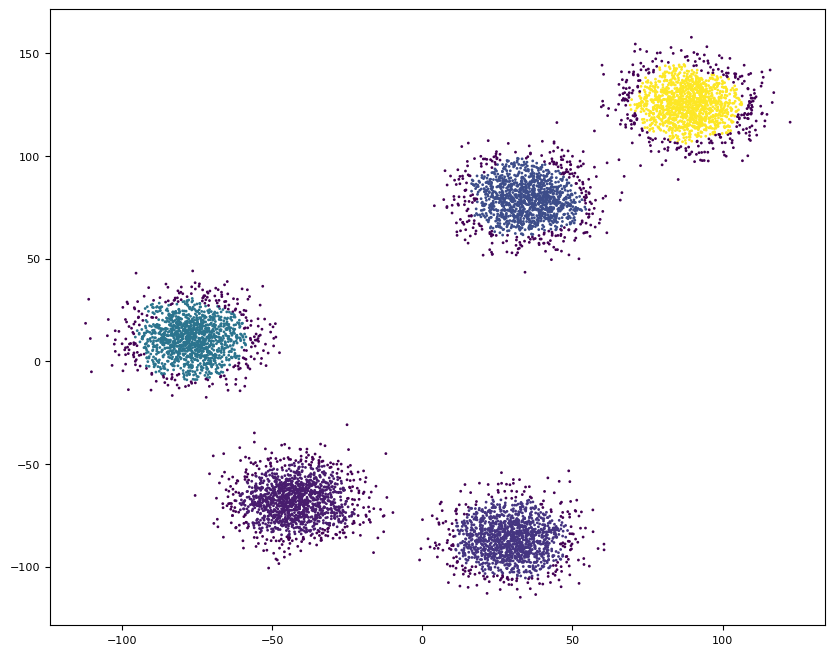

In [305]:
plot_cluster(X, cluster)

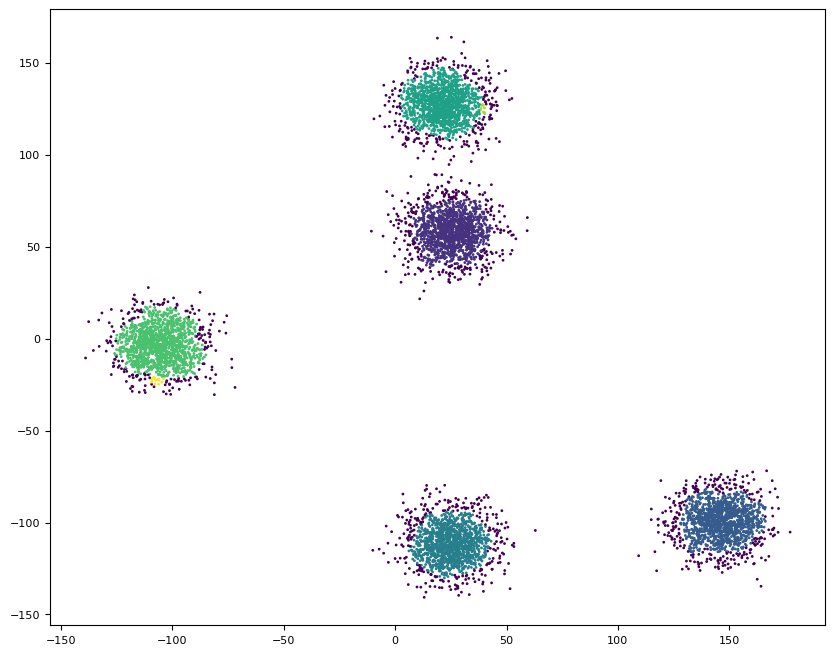

In [52]:
plot_cluster(X, y_pred)